## Market1501 / cuhk03 

{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/storage/DATA/pak'}



/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/storage/DATA/pak/cuhk03_release found :)
/storage/DATA/pak/Market-1501-v15.09.15 found :)
/storage/DATA/pak/DukeMTMC-reID found :)
found memmaped /storage/DATA/pak/cuhk03_release/labeled64x64.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_test64x64.npy
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_train64x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
is same: [1 0]


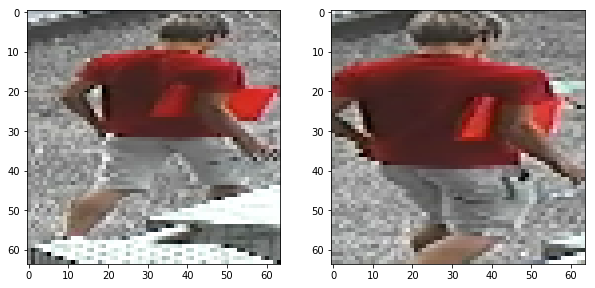

In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

sampler = DataSampler(root, 64, 64)

x, y = sampler.get_test_batch(5, 5)

pid = 3
print('is same:', y[pid])
im = x[pid]
fig = plt.figure(figsize=(10, 6))
fig.add_subplot(121).imshow(im[:,:,0:3])
fig.add_subplot(122).imshow(im[:,:,3:6])
plt.show()

## UMPM dataset

/storage/DATA/pak
UMPM
elapsed 0.93959641456604
same [0 1]


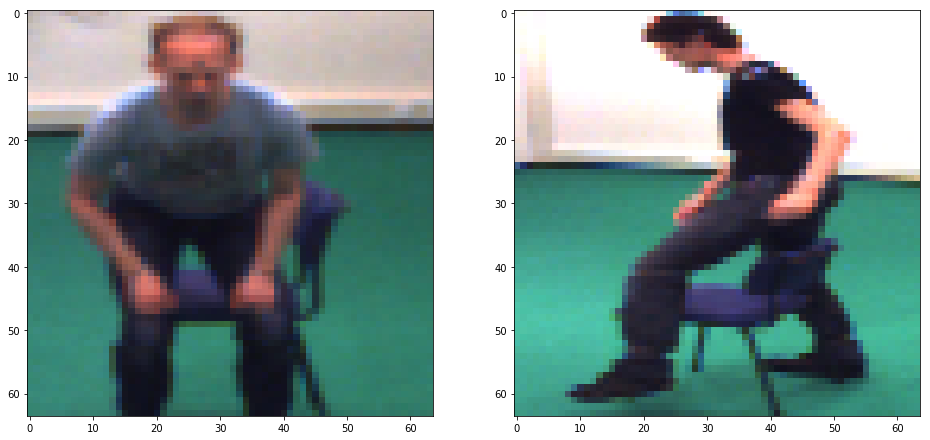

In [2]:
from time import time
from reid.data import UMPMSampler

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, 64, 64)


_start = time()
x, y = umpm_sampler.get_train()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0][0])
ax = fig.add_subplot(122)
ax.imshow(x[0][1])
plt.show()

## MOT16 dataset

In [47]:
from pak.datasets.MOT import MOT16
from pak import utils
from random import random
from numpy.random import randint
import numpy as np

def get_visible_pedestrains(Y_gt):
    """ return people without distractors
    """
    Y_gt = utils.extract_eq(Y_gt, col=7, value=1)
    Y_gt = utils.extract_eq(Y_gt, col=8, value=1)
    return Y_gt

class MOT16Sampler:
    
    def __init__(self, root):
        mot16 = MOT16(root)
        X, _, Y_gt = mot16.get_train("MOT16-02", memmapped=True)
        Y_gt = get_visible_pedestrains(Y_gt)  # only humans
        n_frames, h, w, _ = X.shape
        
        self.lookup = {}
        self.pid_frame_lookup = {}
        self.X = X
        self.n_frames = n_frames
        
        for f in range(n_frames):
            Gt_per_frame = utils.extract_eq(Y_gt, col=0, value=f)
            n = len(Gt_per_frame)
            pids = Gt_per_frame[:,1]
            left = Gt_per_frame[:,2]
            top = Gt_per_frame[:,3]
            width = Gt_per_frame[:,4]
            height = Gt_per_frame[:,5]
            for pid, x, y, w, h in zip(*[pids, left, top, width, height]):
                # only take bbs that are 'big' enough
                if w > 50 and h > 100:
                    pid = int(pid)
                    if pid not in self.lookup:
                        self.lookup[pid] = []
                    self.lookup[pid].append(f)
                    if (pid, f) not in self.pid_frame_lookup:
                        self.pid_frame_lookup[pid, f] = []
                    self.pid_frame_lookup[pid, f].append((x, y, w, h))
        
        print('(MOT16) total number of bounding boxes:', len(self.pid_frame_lookup))
    
    def sample(self, batchsize=16):
        """ get a set of pairs
        """
        pids = list(self.lookup.keys())
        X = []
        Y = []
        for _ in range(batchsize):
            if random() > 0.5:  # get the same pair
                Y.append((1, 0))
            else:  # get a different pair
                Y.append((0, 1))
                f1, f2 = randint(0, self.n_frames, 2)
        
        return np.array(X), np.array(Y)

mot_sampler = MOT16Sampler(root)

X, Y = mot_sampler.sample()


/storage/DATA/pak/MOT16 found :)
MOT16: load memmapped file /storage/DATA/pak/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736


## Training

In [6]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

filepath = join('data_storage', 'model.h5')

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

if isfile(filepath):
    model = load_model(filepath)
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        3520      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [4]:
# def generate_training_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_train_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# def generate_validation_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_test_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# history = model.fit_generator(generate_training_data(),
#                     validation_data=generate_validation_data(),
#                     validation_steps=5,
#                     steps_per_epoch=100,
#                     epochs=1000,
#                     callbacks=callbacks_list)